## Compare Binomial & Multinomial Logistic Regression

> Written by Jess Breda September 2023 post lab meeting

A question that came up (from Carlos) was if the mutli-class model would do better on L/R trials if it was trained on L,R,V. The goal of this notebook is to implement this comparison.

**Initial Steps**:

[X] working with simulated data, figure out the dimensions of the multi-class cost

* follow up questions here if needed

[x] working with simulated data, create a binomial class for fitting (from prev code)

[x] create flexible design matrix for binary/multi

[x] validate binomial class finds athena/nick like results with base regressors

*  start with single animal, then expand

[x] write experiment to sweep sigmas for binomial model

[ ] see what prev_violation regressor does for binomial model

[ ] figure out how to make train/test split for the models
	
* follow up if diff number of training trials might be an issue

* probably don't want to make this perfect now, but long term good to think about & have this information easily stored
		
[ ] determine what the null model comparison would be (if any?)


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pathlib
import sys
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from get_rat_data import *
from animal_performance import *

from method_validation import plot_simulated_weights_binary
from exp_filter import ExpFilter
from binary_logistic_regression import BinaryLogisticRegression

# settings
%load_ext autoreload
%autoreload 2


### Dimensions of multi-class cost

In the test eval of the cost function, I want to squash out the third dimension so the model performs better. Eg [1/3 1/3 1/3] should become [1/2 1/2] (or [1/2 1/2 0], not sure yet). Need to focus on figuring out the cost code.

Answer: wrote a new denominator for softmax that only takes into account L/R trials (log_sum_exp_lr()). 

In [20]:
class MultiClassLogisticRegressionComp:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.W = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X: pd.DataFrame, Y: np.ndarray):
        N, D_w_bias = X.shape
        _, C = Y.shape
        initial_W_flat = np.zeros(D_w_bias * C)

        result = minimize(
            fun=self.cost,
            x0=initial_W_flat,
            args=(X.to_numpy(), Y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.W = result.x.reshape(D_w_bias, C)
        return self.W

    def eval(self, X: pd.DataFrame, Y: np.ndarray):
        return self.cost(self.W, X.to_numpy(), Y, sigma=None)

    def cost(self, W, X, Y, sigma, lr_only=False):
        """
        Compute the negative log-likelihood for multi-class
        logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
            for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied
        lr_only : bool (default=False)
            whether to only consider the first two logits (L and R)
            when computing denominator of softmax

        returns
        -------
        - nll : float
            negative log-likelihood
        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W

        # Only consider the first two logits (L and R)
        # when computing denominator of softmax
        if lr_only:
            log_sum_exp_term = self.log_sum_exp_lr(logits)
        else:
            log_sum_exp_term = self.log_sum_exp(logits)

        penalty = (
            (1 / (2 * (sigma**2))) * np.trace(W[1:, :].T @ W[1:, :]) if sigma else 0
        )
        nll = (-np.sum(Y * logits) + np.sum(log_sum_exp_term)) + penalty
        return nll

    def _gradient(self, W, X, Y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        multi-class logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
        for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D+1 * C)
            gradient of the negative log-likelihood

        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        P = self._stable_softmax(logits)

        if sigma:
            penalty_gradient = W / (sigma**2)
        else:
            penalty_gradient = np.zeros_like(W)

        penalty_gradient[0, :] = 0  # No penalty for bias

        gradient = X.T @ (P - Y) + penalty_gradient
        return gradient.flatten()

    @staticmethod
    def log_sum_exp(logits):
        max_logits = np.max(logits, axis=1, keepdims=True)
        return (
            np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def log_sum_exp_lr(logits):
        max_logits = np.max(
            logits[:, :2], axis=1, keepdims=True
        )  # Only consider the first two logits (L and R)
        return (
            np.log(np.sum(np.exp(logits[:, :2] - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def stable_softmax(logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
        return exp_logits / sum_exp

    def generate_data(self, N, D, C, sigma=None, random_state=None):
        """
        Generate data from a multi-class logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        C : int
            number of classes
        sigma : float (default=None)
            standard deviation of true weight matrix, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, C)
            true weight matrix
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C)
            one-hot encoded choice labels for C classes
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # add bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            W = np.random.normal(loc=0, scale=sigma, size=(D + 1, C))
        else:
            W = np.random.normal(loc=0, scale=1, size=(D + 1, C))

        ## Choice Labels
        A = X @ W  # logits
        P = self.stable_softmax(A)
        Y = np.array([np.random.multinomial(1, n) for n in P])

        print(f"Generated {N} samples with {D} features and {C} classes")
        print(f"W is {W.shape} \nX is {X.shape} \nY is {Y.shape}")
        print(f"W has mean {np.mean(W):.3f} and std {np.std(W):.3f}")

        return W, X, Y

In [21]:
model = MultiClassLogisticRegressionComp(sigma=1)


N = 100000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes
sigma = 1.3
W, X, Y = model.generate_data(N, D, C, sigma=sigma, random_state=44)

Generated 100000 samples with 4 features and 3 classes
W is (5, 3) 
X is (100000, 5) 
Y is (100000, 3)
W has mean -0.277 and std 1.434


In [12]:
"""Testing on all data"""
lronly_cost = model.cost(W, X, Y, sigma, lr_only=True)

cost = model.cost(W, X, Y, sigma, lr_only=False)

print(f"cost with lr_only = True: {lronly_cost:.3f}")
print(f"cost with lr_only = False: {cost:.3f}")

cost with lr_only = True: -11839.363
cost with lr_only = False: 57874.203


In [15]:
Y[-2:-1]  # Left trial

array([[1, 0, 0]])

In [28]:
"""Testing on left trial only"""
y = Y[-2:-1]
x = X[-2:-1]

lronly_cost = model.cost(W, x, y, sigma, lr_only=True)
cost = model.cost(W, x, y, sigma, lr_only=False)


print(f"cost with lr_only = True: {lronly_cost:.3f}")
print(f"cost with lr_only = False: {cost:.3f}")

cost with lr_only = True: 7.148
cost with lr_only = False: 8.056


## Binary Logistic Regression

### Validate model on simulated data

In [2]:
bmodel = BinaryLogisticRegression(sigma=20)
w, X, y = bmodel.generate_data(N=1000, D=2, sigma=1, random_state=None)
result = bmodel.fit(X, y)

Generated 1000 samples with 2 features
w is (3,) 
X is (1000, 3) 
y is (1000,)
w has mean -0.472 and std 0.576
         Current function value: 0.534533
         Iterations: 11
         Function evaluations: 51
         Gradient evaluations: 39


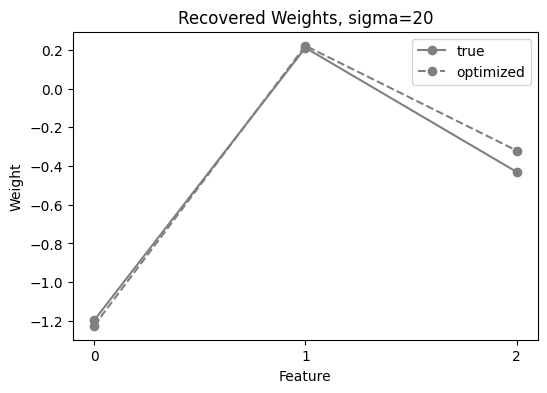

In [3]:
plot_simulated_weights_binary(
    w, result.x, title=f"Recovered Weights, sigma={bmodel.sigma}"
)

         Current function value: 0.670252
         Iterations: 1
         Function evaluations: 52
         Gradient evaluations: 40


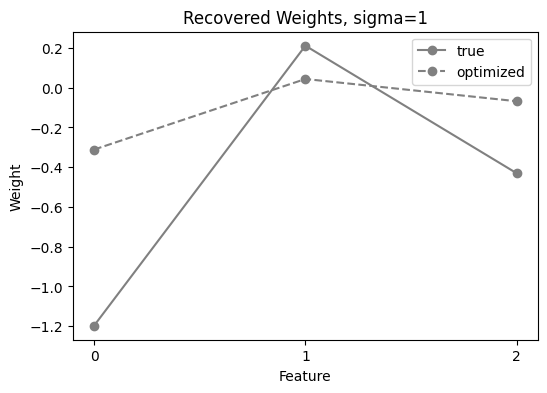

In [4]:
bmodel.sigma = 1
result = bmodel.fit(X, y)

plot_simulated_weights_binary(
    w, result.x, title=f"Recovered Weights, sigma={bmodel.sigma}"
)

The regularization term effects the ability to recover weights from simulated data. Specifically, a smaller (stronger) sigma gets stuck in a local minima. Made some slides with this summary and plan to continue moving forward

### Recreate Athena/Roy Results

In [45]:
class DesignMatrixGeneratorBinaryMulti:
    def __init__(self, animal_id, verbose=True):
        self.verbose = verbose
        self.animal_id = animal_id

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(
        self,
        df,
        mode="binary",
        violations="none",
        tau=None,
        return_labels=True,
        drop_session_column=False,
    ):
        """
        Function to generate "base" design matrix given a dataframe
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack.

        N = number of trials
        D = number of features

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        mode : str (default="binary")
            wether to use binary or multi-class logistic regression
        violations : str (default="none")
            whether to include violations as a regressor an if so,
            in what form ("prev", "exp" or "none")
        tau: float (default=None)
            if violations is "exp", tau is the time constant for
            the exponential filter (usually animal specific)
        return_label : bool (default = True)
            whether to return one-hot encoded choice labels
        drop_session_column : bool (default = False)
            whether to drop 'session' column. should be set to
            false if doing session based train/test split
            following design matrix generation

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, 3) if multi-class (N, ) if binary
            when return_labels=True.
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]
        X["session"] = df.session

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        X["prev_violation"] = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0)
        prev_violation_mask = X["prev_violation"] == 0

        # # Violation Exp Filter
        if mode == "multi":
            if violations == "exp":
                self.exp_filter = ExpFilter(
                    tau=tau, verbose=self.verbose, column="prev_violation"
                )
                self.exp_filter.apply_filter_to_dataframe(X)
                X.drop(columns=["prev_violation"], inplace=True)
            elif violations == "none":
                X.drop(columns=["prev_violation"], inplace=True)

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        # if binary, drop the violation trials
        if mode == "binary":
            X = X[df["violation"] != 1].reset_index(drop=True)
            X.drop(columns=["prev_violation"], inplace=True)

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        if drop_session_column:
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            if mode == "binary":
                # make choice vector L -> -1, R -> 1, drop nans (violations) to match X
                Y = (
                    df["choice"]
                    .dropna()
                    .replace({0: -1})
                    .dropna()
                    .astype(int)
                    .to_numpy()
                )
            elif mode == "multi":
                Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    @staticmethod
    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

    def get_train_test_sessions(self, df, test_size, random_state=45):
        """
        This function will return a list of sessions to use for training
        and testing respectively. To apply, see function
        see apply_session_train_test_split()


        Parameters:
        -----------
        df : pd.DataFrame
            dataframe with `sessions` column
        test_size : float
            Proportion of data to use for test set
        """
        unique_sessions = df["session"].unique()
        train_sessions, test_sessions = train_test_split(
            unique_sessions, test_size=test_size, random_state=random_state
        )

        self.train_sessions = train_sessions
        self.test_sessions = test_sessions

    def apply_session_train_test_split(self, X, Y):
        """
        train_sessions = np.array
            sessions for the
        test_values = np.array indices for the test values

        """
        # TODO add in a check to see if self._train_session
        # TODO exists, and if not, call get_train_test_sessions

        # Filter rows based on session values for X
        X_train = X[X["session"].isin(self.train_sessions)].copy()
        X_test = X[X["session"].isin(self.test_sessions)].copy()

        # Filter rows based on session values for Y
        # Assuming the index of Y corresponds to that of X
        Y_train = Y[X["session"].isin(self.train_sessions).values]
        Y_test = Y[X["session"].isin(self.test_sessions).values]

        X_train.drop(columns=["session"], inplace=True)
        X_test.drop(columns=["session"], inplace=True)

        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

        return X_train, X_test, Y_train, Y_test

In [95]:
def plot_weights(X, w, ax=None):
    """
    Plots the weights for each column in the design matrix X.

    Parameters:
    X (numpy.ndarray): The design matrix with shape (m, n)
    w (numpy.ndarray): The weight vector with shape (n,)

    """

    # if X is a df, grab the columns
    if isinstance(X, pd.DataFrame):
        X = X.columns

    if len(X) != len(w):
        raise ValueError("The number of columns in X must match the length of w.")
    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(X, w)
    ax.axhline(0, color="black")

    # aesthetics
    plt.xticks(rotation=45)
    ax.set(
        xlabel="Feature",
        ylabel="Weight Value",
        title="Weight by Feature",
    )

In [90]:
animal_id = "W078"

dmg = DesignMatrixGeneratorBinaryMulti(verbose=False, animal_id=animal_id)


animal_df = get_rat_viol_data(animal_ids=animal_id)

X, y = dmg.generate_design_matrix(
    animal_df,
    mode="binary",
    violations="exp",
    tau=5,
    return_labels=True,
    drop_session_column=True,
)

bmodel = BinaryLogisticRegression(sigma=3, method="L-BFGS-B")
result = bmodel.fit(X, y)

plot_weights(X, result.x)

returning viol data for W078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84874D-01    |proj g|=  5.75731D-01


 This problem is unconstrained.



At iterate    1    f=  2.68415D-01    |proj g|=  3.80341D-01

At iterate    2    f=  2.31055D-02    |proj g|=  1.47477D-01

At iterate    3    f=  2.22476D-02    |proj g|=  1.45262D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     53      2     0     0   1.453D-01   2.225D-02
  F =   2.2247580063747996E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


NameError: name 'plot_weights' is not defined

BFGS seems to be having issues, but the weights look as expected. This animal happens to be trained, so sa/sb are opposite and opposed. For other animals (e.g. "W065") this is not the case and the weights favor sb much more. it should be noted that at the trunction for the violations datasets no animals had psychometric stimuli! this also leads to poor fits. 

returning full data for W078


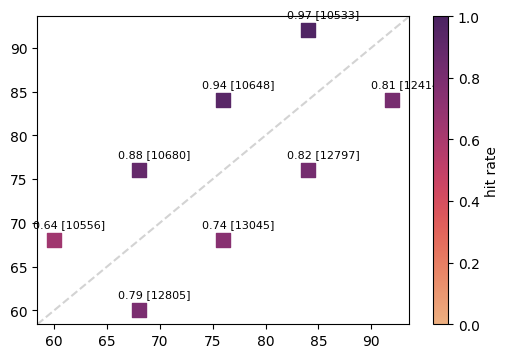

In [29]:
plot_animal_performance_by_stim(animal_id, violations_only=False)

returning viol data for W078


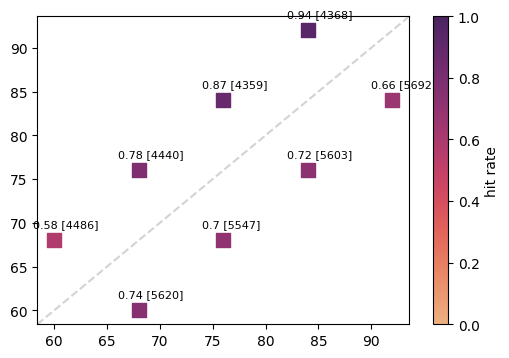

In [30]:
plot_animal_performance_by_stim(animal_id, violations_only=True)

From the plots above, you can see that the full dataset (upper plot) has higher performance and counts for the stimulus pairs. These are across all stages/sessions with stim pairs. I will also fit the model to the full dataset to see the differences in weights. The BFGS errors still persist.

returning full data for W078


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49875D-01    |proj g|=  5.17016D-01

At iterate    1    f=  1.75552D-01    |proj g|=  3.34616D-01

At iterate    2    f= -5.95725D-02    |proj g|=  1.32431D-01

At iterate    3    f= -5.99373D-02    |proj g|=  1.30195D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     51      2     0     0   1.302D-01  -5.994D-02
  F =  -5.9937281309924595E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


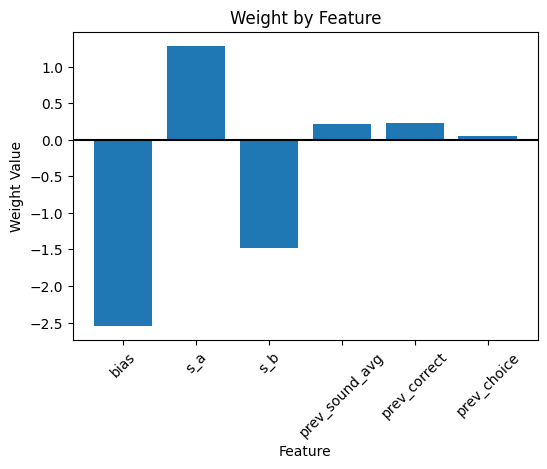

In [32]:
# Get data for a single animal
animal_df = get_rat_data(animal_ids=animal_id)

X, y = dmg.generate_design_matrix(
    animal_df,
    mode="binary",
    violations="none",
    tau=5,
    return_labels=True,
    drop_session_column=True,
)

bmodel = BinaryLogisticRegression(sigma=3, method="L-BFGS-B")
result = bmodel.fit(X, y)

plot_weights(X, result.x)

### Develop a SigmaSearchBinary Experiment


In [59]:
class SigmaSearchBinary:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.model_names = params["model_names"]
        self.random_state = params["random_state"]
        self.tau = np.nan
        self.test_size = params["test_size"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []

        if self.animals is None:
            self.animals = self.df.animal_id.unique()
        self.n_animals = len(self.animals)

    def run(self):
        for animal in self.animals:
            print(f"\n\n !!!!! evaluating animal {animal} !!!!!\n\n")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGeneratorBinaryMulti(verbose=False, animal_id=animal)
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # Iterate over sigmas
            for sigma in self.sigmas:
                # Generate design matrix & create train/test splits
                X, y = dmg.generate_design_matrix(
                    animal_df,
                    mode="binary",
                    violations="none",
                    tau=self.tau,
                    return_labels=True,
                )

                print(
                    f"model : {self.model_names}, sigma: {sigma}, tau: {self.tau}, size of X: {X.shape}, Y: {y.shape}"
                )
                (
                    X_train,
                    X_test,
                    y_train,
                    y_test,
                ) = dmg.apply_session_train_test_split(X, y)

                # Fit model & evaluate
                model = BinaryLogisticRegression(sigma=sigma)
                w_fit = model.fit(X_train, y_train)
                nll = model.eval(X_test, y_test)

                # Store model_fits
                self.store(
                    animal,
                    self.model_names[0],
                    nll,
                    sigma,
                    self.tau,
                    w_fit,
                    dmg,
                )

        self.model_fits = pd.concat(self.stored_fits, ignore_index=True)
        return self.model_fits

    def store(self, animal, model_name, nll, sigma, tau, w_fit, dmg):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "tau": [tau],
                "features": [list(dmg.X_test.columns)],
                "weights": [list(w_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

In [112]:
params = {
    "animals": None,
    "sigmas": [0.13, 0.25, 0.5, 1, 2, 4, 8],  # [0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "model_names": ["base"],
    "random_state": 47,
    "test_size": 0.25,
}

experiment = SigmaSearchBinary(params)
results = experiment.run()

returning viol dataset for all animals


 !!!!! evaluating animal W051 !!!!!


model : ['base'], sigma: 0.13, tau: nan, size of X: (46800, 7), Y: (46800,)
         Current function value: 0.789913
         Iterations: 1
         Function evaluations: 57
         Gradient evaluations: 45
model : ['base'], sigma: 0.25, tau: nan, size of X: (46800, 7), Y: (46800,)
         Current function value: 0.786104
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 36
model : ['base'], sigma: 0.5, tau: nan, size of X: (46800, 7), Y: (46800,)
         Current function value: 0.670520
         Iterations: 1
         Function evaluations: 56
         Gradient evaluations: 44
model : ['base'], sigma: 1, tau: nan, size of X: (46800, 7), Y: (46800,)
         Current function value: 0.572645
         Iterations: 1
         Function evaluations: 53
         Gradient evaluations: 41
model : ['base'], sigma: 2, tau: nan, size of X: (46800, 7), Y: (46800,)
         Current

In [115]:
from model_visualizer import ModelVisualizer

mv = ModelVisualizer(experiment)

In [116]:
mv

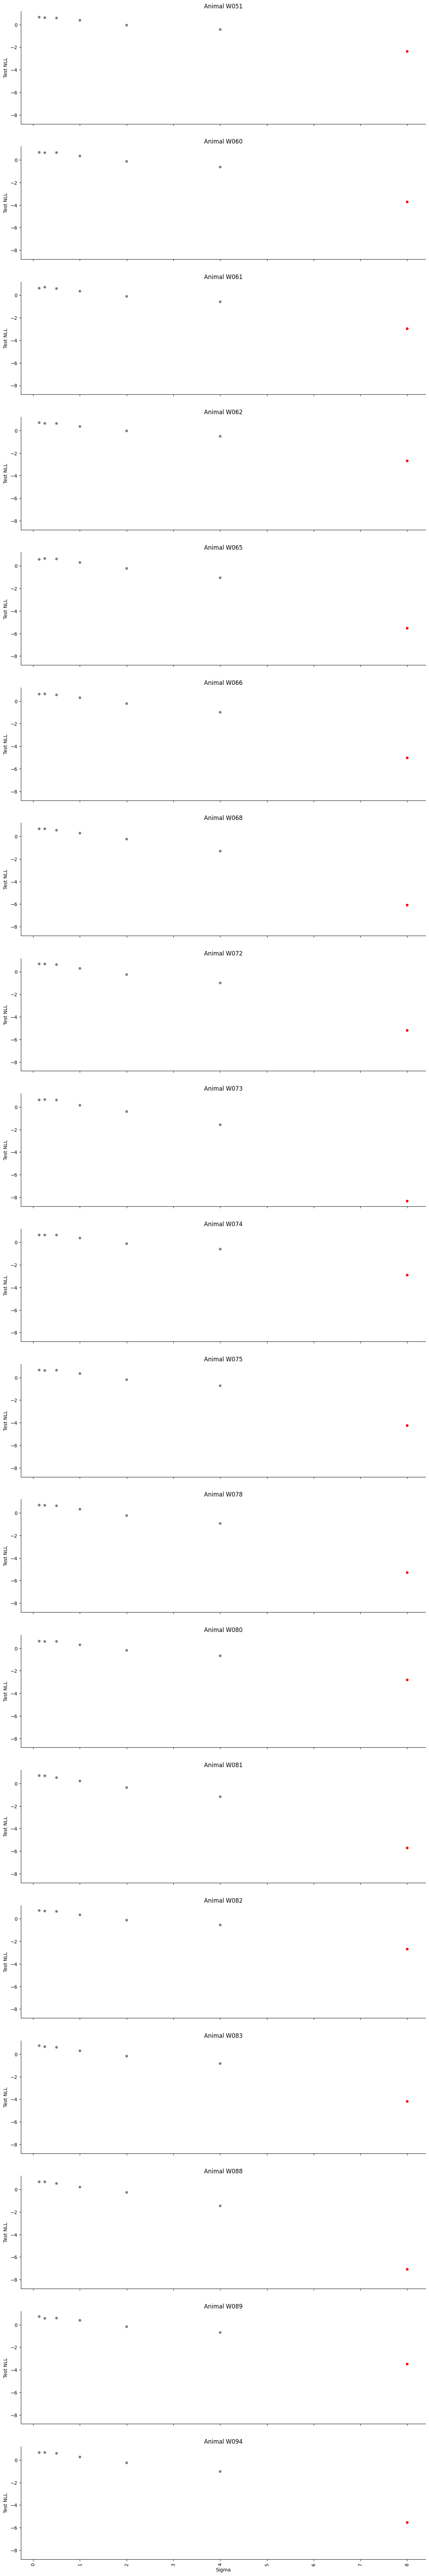

In [117]:
# Plot nll over sigmas

mv.plot_nll_over_sigmas_by_animal()

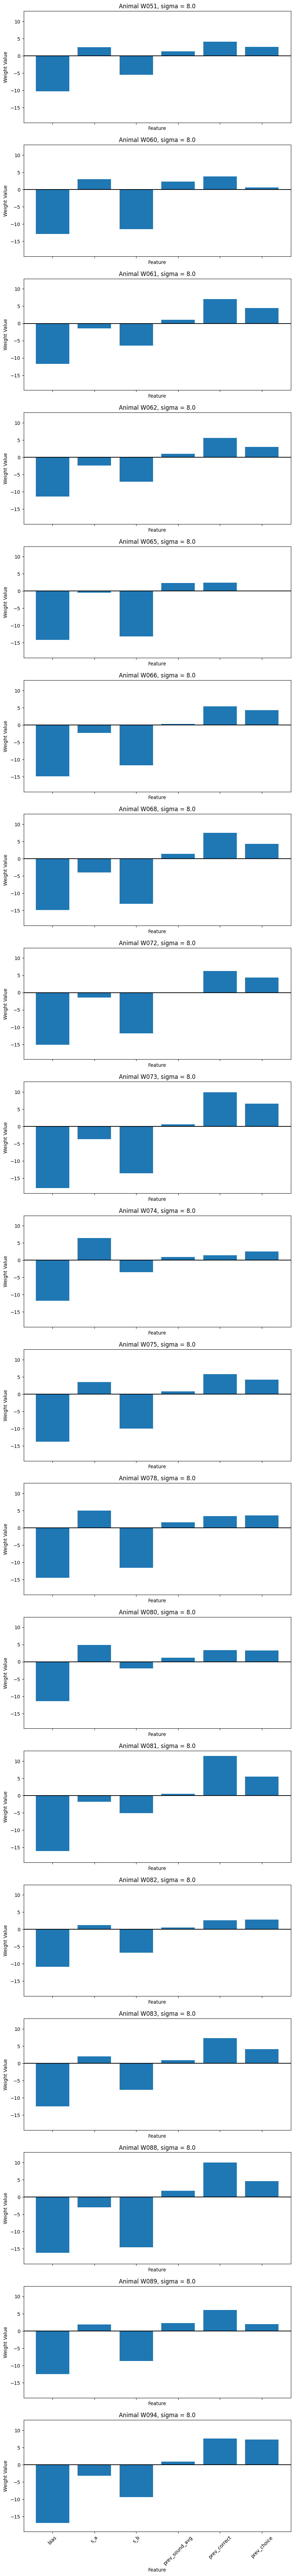

In [119]:
# plot_weights_by_animal

bf = mv.find_best_fit(group="animal_id")

n_animals = bf.animal_id.nunique()

fig, ax = plt.subplots(
    n_animals, 1, figsize=(10, 5 * n_animals), sharex=True, sharey=True
)

for i, animal in enumerate(bf.animal_id.unique()):
    animal_df = bf.query("animal_id == @animal")
    plot_weights(
        animal_df.features.values[0],
        animal_df.weights.values[0],
        ax=ax[i],
    )
    ax[i].set_title(f"Animal {animal}, sigma = {animal_df.sigma.values[0]}")